# Power   VS   Finess

#### 투수의 유형을 나눌 때, Power pitcher와 Finess pitcher로 구분하는 경우가 있다.
Power pitcher는 공의 정확도보다 속도에 집중해서 투구를 하는 유형의 투수 유형이고,   
반대로 Finess pitcher는 공의 속도보다 정확도에 집중해서 제구력을 높인 투수의 유형이다.   
   
두 유형을 구속으로만 분류해서 기록을 살펴보자.   
(Power: 95 mph 이상, Finess: 95 mph 이하)

### Data From   ( Kaggle & Lahman Basball Database )

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
# 선수 명단
player = pd.read_csv('People.csv')
player['fullName'] = player['nameFirst']+' '+player['nameLast']
player_id = player[['playerID', 'fullName', 'bats', 'throws']]
player_id

In [3]:
# 투수들의 경기 기록 
pitch = pd.read_csv('Pitching.csv')

Index(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'W', 'L', 'G', 'GS',
       'CG', 'SHO', 'SV', 'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp',
       'ERA', 'IBB', 'WP', 'HBP', 'BK', 'BFP', 'GF', 'R', 'SH', 'SF', 'GIDP'],
      dtype='object')

In [ ]:
# 타자들의 경기 기록
bat = pd.read_csv('Batting.csv')

In [12]:
# 투구 데이터
p_data = pd.read_csv('pitches.csv')

In [17]:
# 타석 데이터
b_data = pd.read_csv('atbats.csv')

In [22]:
# 타석 + 투구 데이터
player_name = pd.read_csv('player_names.csv')
player_name['full_name'] = player_name['first_name'] + ' ' + player_name['last_name']
plus_bat = pd.merge(b_data, player_name[['id', 'full_name']], left_on='batter_id', right_on='id').rename(columns={'full_name': 'batter_name'})
plus_pit = pd.merge(plus_bat, player_name[['id', 'full_name']], left_on='pitcher_id', right_on='id').rename(columns={'full_name': 'pitcher_name'})
pit_bat = plus_pit.drop(['id_x', 'id_y'], axis=1)
total = pd.merge(p_data, pit_bat, on='ab_id')

In [24]:
# 투수의 구종별 평균 구속
mlb_mean = total.groupby('pitch_type')[['pitch_type','start_speed']].mean().sort_values(by='start_speed', ascending=False).reset_index()
pitcher_speed = total.groupby(['pitcher_name','pitch_type'])['start_speed'].mean().reset_index()
pitcher_speed

,pitcher_name,pitch_type,start_speed
0,A.J. Achter,CH,82.890747
1,A.J. Achter,FC,89.833333
2,A.J. Achter,FF,90.714559
3,A.J. Achter,FT,90.605051
4,A.J. Achter,IN,63.820000
...,...,...,...
6889,Zack Wheeler,CU,79.003495
6890,Zack Wheeler,FF,95.447422
6891,Zack Wheeler,FS,89.007542
6892,Zack Wheeler,FT,95.309517


Text(0.5, 1.0, 'MLB FF+FT Velocity Distribution (MPH)')

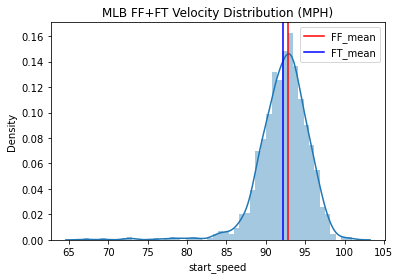

In [25]:
# 패스트볼(FF + FT) 평균 구속의 분포와 mlb 평균
ff_or_ft = pitcher_speed[(pitcher_speed['pitch_type']=='FF')|(pitcher_speed['pitch_type']=='FT')]
p_speed = ff_or_ft.groupby('pitcher_name')[['pitch_type', 'start_speed']].max().reset_index()
sns.distplot(p_speed['start_speed'])
plt.axvline(mlb_mean['start_speed'].loc[0], color='r', label='FF_mean')
plt.axvline(mlb_mean['start_speed'].loc[1], color='b', label='FT_mean')
plt.legend()
plt.title('MLB FF+FT Velocity Distribution (MPH)')

## Power Pitcher(PP): 평균 구속 95 mph 이상
## Finess Pitcher(FP): 평균 구속 95 mph 이하

In [33]:
power = p_speed[p_speed['start_speed']>95].reset_index().drop('index', axis=1)
finess = p_speed[p_speed['start_speed']<=95].reset_index().drop('index', axis=1)
power_pitcher = pd.merge(player_id, power['pitcher_name'], left_on='fullName', right_on='pitcher_name')
finess_pitcher = pd.merge(player_id, finess['pitcher_name'], left_on='fullName', right_on='pitcher_name')

In [57]:
pp_record = pd.merge(pitch, power_pitcher, on='playerID')
fp_record = pd.merge(pitch, finess_pitcher, on='playerID')


In [90]:
pp_fp_record = pd.merge(pp_record[['H', 'HR', 'BB', 'SO', 'ERA', 'WP']].mean().reset_index().rename(columns={0: 'pp'}),
                       fp_record[['H', 'HR', 'BB', 'SO', 'ERA', 'WP']].mean().reset_index().rename(columns={0: 'fp'}),
                       on='index')
pp_fp_record = pp_fp_record.set_index('index').transpose()
pp_fp_record

index,H,HR,BB,SO,ERA,WP
pp,45.015385,5.409615,18.716346,51.116346,5.063013,2.617308
fp,61.976214,7.676768,21.859726,54.874226,5.112892,2.353372


Text(0.5, 1.0, 'Wild Pitches')

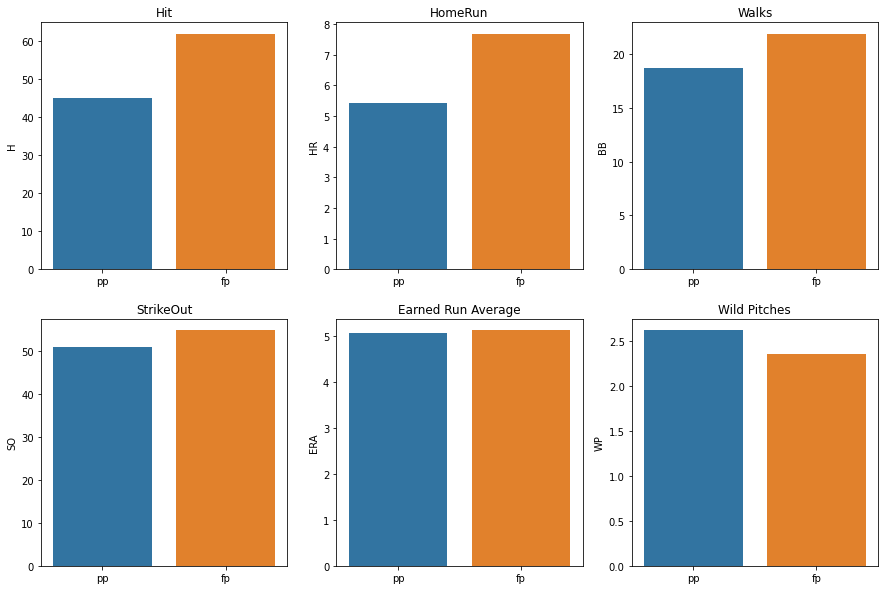

In [89]:
plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
sns.barplot(x=pp_fp_record.index, y=pp_fp_record['H'])
plt.title('Hit')
plt.subplot(2,3,2)
sns.barplot(x=pp_fp_record.index, y=pp_fp_record['HR'])
plt.title('HomeRun')
plt.subplot(2,3,3)
sns.barplot(x=pp_fp_record.index, y=pp_fp_record['BB'])
plt.title('Walks')
plt.subplot(2,3,4)
sns.barplot(x=pp_fp_record.index, y=pp_fp_record['SO'])
plt.title('StrikeOut')
plt.subplot(2,3,5)
sns.barplot(x=pp_fp_record.index, y=pp_fp_record['ERA'])
plt.title('Earned Run Average')
plt.subplot(2,3,6)
sns.barplot(x=pp_fp_record.index, y=pp_fp_record['WP'])
plt.title('Wild Pitches')

안타 수, 홈런 수, 사구는 Power pitcher들 보다 Finess pitcher가 높은 수치를 기록했다.(Power pitcher의 기록이 좋음)   
Wild Pitch 수는 Power pitcher들이 더 높았고, ERA는 미세하게 Power pitcher가 좋은 기록을 했다.   
삼진아웃 숫자는 Power pitcher보다 Finess pitcher가 더 많았다.

# 선발진들의 기록을 살펴보자

In [93]:
# 선발 출장 10경기 이상
pp_starter = pp_record[pp_record['GS']>10]
fp_starter = ff_record[ff_record['GS']>10]
fp_starter

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,BFP,GF,R,SH,SF,GIDP,fullName,bats,throws,pitcher_name
9,rodried01,1976,1,ML4,AL,5,13,45,12,3,...,584.0,26,68,10.0,8.0,11.0,Eduardo Rodriguez,R,R,Eduardo Rodriguez
48,hawkila01,1997,1,MIN,AL,6,12,20,20,0,...,478.0,0,71,2.0,2.0,17.0,LaTroy Hawkins,R,R,LaTroy Hawkins
49,hawkila01,1998,1,MIN,AL,7,14,33,33,0,...,840.0,0,126,4.0,10.0,24.0,LaTroy Hawkins,R,R,LaTroy Hawkins
50,hawkila01,1999,1,MIN,AL,10,14,33,33,1,...,803.0,0,136,1.0,5.0,16.0,LaTroy Hawkins,R,R,LaTroy Hawkins
70,colonba01,1997,1,CLE,AL,4,7,19,17,1,...,427.0,0,66,4.0,1.0,11.0,Bartolo Colon,R,R,Bartolo Colon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6080,suarean01,2018,1,SFN,NL,7,13,29,29,0,...,665.0,0,85,5.0,6.0,22.0,Andrew Suarez,L,L,Andrew Suarez
6096,turnbsp01,2019,1,DET,AL,3,17,30,30,0,...,656.0,0,86,1.0,4.0,11.0,Spencer Turnbull,R,R,Spencer Turnbull
6097,turnbsp01,2020,1,DET,AL,4,4,11,11,0,...,242.0,0,25,2.0,1.0,6.0,Spencer Turnbull,R,R,Spencer Turnbull
6111,vothau01,2020,1,WAS,NL,2,5,11,11,1,...,225.0,0,36,0.0,0.0,4.0,Austin Voth,R,R,Austin Voth


In [96]:
starter_record = pd.merge(pp_starter[['W','L', 'H', 'HR', 'BB', 'SO', 'ERA', 'WP']].mean().reset_index().rename(columns={0: 'pp'}),
                       fp_starter[['W','L', 'H', 'HR', 'BB', 'SO', 'ERA', 'WP']].mean().reset_index().rename(columns={0: 'fp'}),
                       on='index')
starter_record = starter_record.set_index('index').transpose()
starter_record

index,W,L,H,HR,BB,SO,ERA,WP
pp,9.340909,7.159091,128.272727,14.971591,44.312500,134.750000,3.862045,5.261364
fp,8.739401,8.198982,140.496326,17.206897,45.882985,118.519503,4.233262,4.551724


Text(0.5, 1.0, 'Loses')

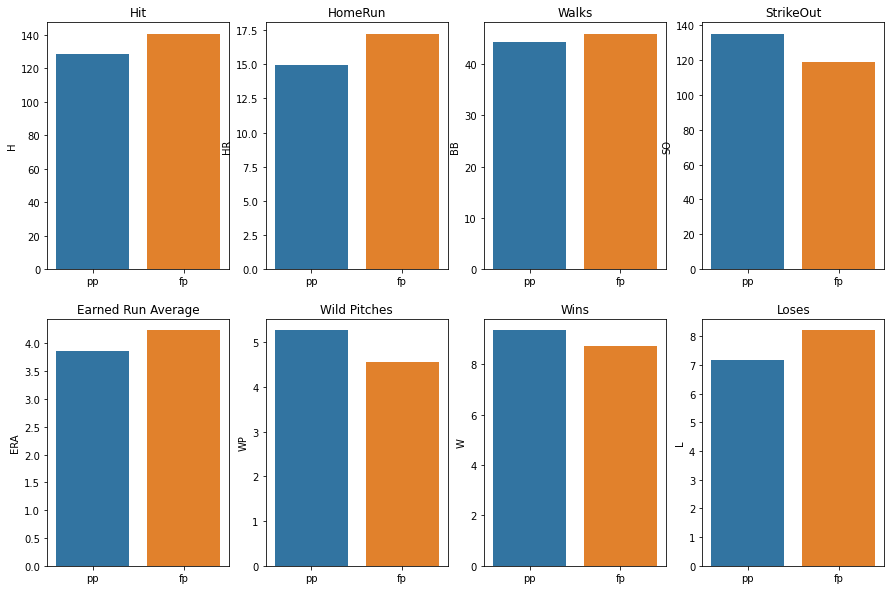

In [99]:
plt.figure(figsize=(15,10))
plt.subplot(2,4,1)
sns.barplot(x=starter_record.index, y=starter_record['H'])
plt.title('Hit')
plt.subplot(2,4,2)
sns.barplot(x=starter_record.index, y=starter_record['HR'])
plt.title('HomeRun')
plt.subplot(2,4,3)
sns.barplot(x=pp_fp_record.index, y=starter_record['BB'])
plt.title('Walks')
plt.subplot(2,4,4)
sns.barplot(x=starter_record.index, y=starter_record['SO'])
plt.title('StrikeOut')
plt.subplot(2,4,5)
sns.barplot(x=starter_record.index, y=starter_record['ERA'])
plt.title('Earned Run Average')
plt.subplot(2,4,6)
sns.barplot(x=starter_record.index, y=starter_record['WP'])
plt.title('Wild Pitches')
plt.subplot(2,4,7)
sns.barplot(x=starter_record.index, y=starter_record['W'])
plt.title('Wins')
plt.subplot(2,4,8)
sns.barplot(x=starter_record.index, y=starter_record['L'])
plt.title('Loses')

전체와는 반대로, 삼진아웃 숫자가 Power pitcher가 더 높게 기록되었다.   
선발진의 기록도 전체적으로 Power pitcher가 더 좋게 기록되었고, 추가된 승/패도 Power pitcher가 더 좋은 성적을 기록했다.